Title: The effect of human mobility on endemic size

# Backgroud: SIS Reaction diffusion model

Considering the following endemic problem of SIS reaction diffusion model:

$$
\left\{\begin{array}{l}
 d_{S} S_{x x}-\beta(x) \frac{S I}{S+I}+\gamma(x) I = 0, \quad 0<x<1 \\
 d_{I} I_{x x}+\beta(x) \frac{S I}{S+I}-\gamma(x) I = 0, \quad 0<x<1 \\
S_{x}=I_{x}=0, \quad x=0,1,
\end{array}\right.
$$

where $\int_{0}^{1} S(x)+I(x)dx = 1$.

Set $$f(d_{S},d_{I}) = \int_{0}^{1}I(x;d_{S},d_{I}).$$

Question: level set of function $f(d_{S},d_{I})$ under some spectial $\beta(x),\gamma(x)$?


# Setting up SIS reaction-diffusion model

## Loading packages


In [1]:
# Loading packages
using DifferentialEquations, ModelingToolkit, MethodOfLines, DomainSets, Plots, NLsolve, Sundials, ProgressBars, LoopVectorization

## Model set up


In [ ]:
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets, Plots
# Parameters, variables, and derivatives
@parameters t x
@parameters dS dI brn ϵ
@variables S(..) I(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2

# Define functions
function γ(x)
    y = x + 1.0
    return y
end

function ratio(x, brn, ϵ)
    y = brn + ϵ * sin(2 * pi * x)
    return y
end

# 1D PDE and boundary conditions
eq = [Dt(S(t, x)) ~ dS * Dxx(S(t, x)) - ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) + γ(x) * I(t, x),
    Dt(I(t, x)) ~ dI * Dxx(I(t, x)) + ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) - γ(x) * I(t, x)]
bcs = [S(0, x) ~ 0.9 + 0.1 * sin(2 * pi * x),
    I(0, x) ~ 0.1 + 0.1 * cos(2 * pi * x),
    Dx(S(t, 0)) ~ 0.0,
    Dx(S(t, 1)) ~ 0.0,
    Dx(I(t, 0)) ~ 0.0,
    Dx(I(t, 1)) ~ 0.0]

# Space and time domains
domains = [t ∈ Interval(0.0, 10.0),
    x ∈ Interval(0.0, 1.0)]

# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [S(t, x), I(t, x)], [dS => 0.5, dI => 0.1, brn => 3, ϵ => 0.1])

# Method of lines discretization
# Need a small dx here for accuracy
dx = 0.01
order = 2
discretization = MOLFiniteDifference([x => dx], t)

# Convert the PDE problem into an ODE problem
prob = discretize(pdesys, discretization)




## Solving time dependent SIS model


In [3]:
# Solve ODE problem
sol = solve(prob, Tsit5(), saveat=0.2);

Retriving results


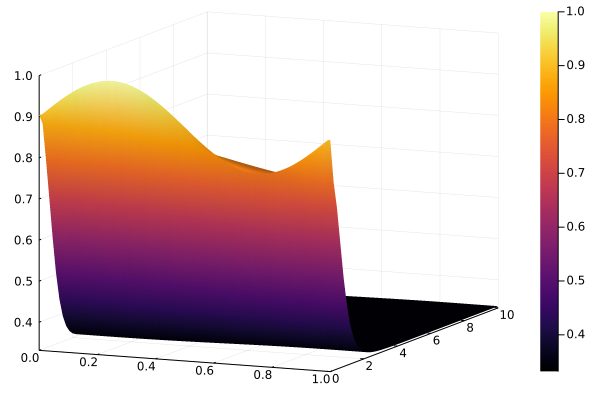

In [4]:
grid = get_discrete(pdesys, discretization)
discrete_x = grid[x]
discrete_t = sol[t]
solS = [map(d -> sol[d][i], grid[S(t, x)]) for i in 1:length(sol[t])]
solI = [map(d -> sol[d][i], grid[I(t, x)]) for i in 1:length(sol[t])]
S_solution = zeros(length(discrete_t), length(discrete_x))
I_solution = zeros(length(discrete_t), length(discrete_x))
for i in 1:length(discrete_t)
    S_solution[i, :] = solS[i]
    I_solution[i, :] = solI[i]
end
S_solution
p = surface(discrete_x, discrete_t, S_solution)
display(p)


## Solving Steady State Problem


In [ ]:
using DifferentialEquations
steadystateprob = SteadyStateProblem(prob)
state = solve(steadystateprob, DynamicSS(Tsit5()))


In [ ]:
function episize!(dS, dI)
    newprob = remake(prob, p=[dS, dI, 3, 0.1])
    steadystateprob = SteadyStateProblem(newprob)
    state = solve(steadystateprob, DynamicSS(Tsit5()))
    y = sum(state[100:end]) / 99
    return y
end
episize!(exp(1.0),exp(0.5))

# Epidemic size f(dS,dI) under condition $\gamma(x) = x+1, \frac{\beta(x)}{\gamma(x)} = 3 + 0.01 * sin(2\pi  x)$

Change $\beta(x), \gamma(x), dS, dI$


## Precompiling the codes


In [ ]:
# Define functions
## recovery_rate function
function γ(x)
    y = x + 1.0
    return y
end
## ratio function of beta/gamma
function ratio(x, brn, ϵ)
    y = brn + ϵ * sin(2 * pi * x)
    return y
end
## initial value function
function initS(x)
    y = 0.9 + 0.1 * sin(2 * pi * x)
    return y
end
function initI(x)
    y = 0.1 + 0.1 * cos(2 * pi * x)
    return y
end


# Parameters, variables, and derivatives
@parameters t x
@parameters dS dI brn ϵ
@variables S(..) I(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2
# 1D PDE and boundary conditions
eq = [Dt(S(t, x)) ~ dS * Dxx(S(t, x)) - ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) + γ(x) * I(t, x),
    Dt(I(t, x)) ~ dI * Dxx(I(t, x)) + ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) - γ(x) * I(t, x)]
bcs = [S(0, x) ~ initS(x),
    I(0, x) ~ initI(x),
    Dx(S(t, 0)) ~ 0.0,
    Dx(S(t, 1)) ~ 0.0,
    Dx(I(t, 0)) ~ 0.0,
    Dx(I(t, 1)) ~ 0.0]
# Space and time domains
domains = [t ∈ Interval(0.0, 5.0),
    x ∈ Interval(0.0, 1.0)]
# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [S(t, x), I(t, x)], [dS => 0.5, dI => 0.1, brn => 3.0, ϵ => 0.1])
# Method of lines discretization
# Need a small dx here for accuracy
dx = 0.01
order = 2
discretization = MOLFiniteDifference([x => dx], t)

# Convert the PDE problem into an ODE problem
prob = discretize(pdesys, discretization)

# Solve ODE problem
# sol = solve(prob, Tsit5(), saveat=0.2);

# Slove SteadyState Problem
steadystateprob = SteadyStateProblem(prob)
state = solve(steadystateprob, DynamicSS(Tsit5()))
sum(state)


## Parallel computing

Here $$\gamma(x) = x+1, \frac{\beta(x)}{\gamma(x)} = 3 + 0.01 * sin(2\pi  x)$$ and $$d_S, d_I \in [\exp(-5),\exp(5)$$


In [7]:
using ProgressBars
function episize!(dS, dI)
    newprob = remake(prob, p=[dS, dI, 3, 0.1])
    steadystateprob = SteadyStateProblem(newprob)
    state = solve(steadystateprob, DynamicSS(Tsit5()))
    y = sum(state[100:end]) / 99
    return y
end
episize!(exp(1.0),exp(0.5))

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://diffeq.sciml.ai/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase F:\Code\Julia\Julia-1.6.2\jpkgs\.julia\packages\SciMLBase\7S5Sx\src\integrator_interface.jl:352


0.6656214868938581

## Fix $d_{I} =1$, change $d_{S}$

$$d_S \in [\exp(-2),\exp(5)], d_I = 1$$


In [ ]:
d_min = -2.0
d_max = 5.0
N_len = 50
N_range = range(d_min, d_max, length=N_len)
episize_vector_S = zeros(N_len)
Threads.@threads for j in ProgressBar(1:N_len)
        episize_vector_S[j] = episize(exp(N_range[j]), 1.0)
end
episize_vector_S;

$$\gamma(x) = x+1, \frac{\beta(x)}{\gamma(x)} = 3 + 0.01 * sin(2\pi  x), d_S \in [\exp(-2),\exp(5)], d_I = 1$$


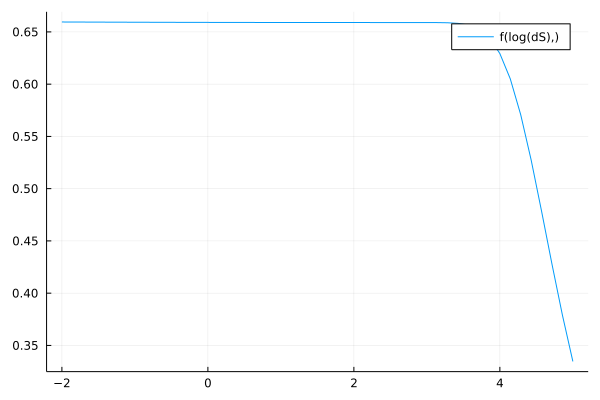

In [22]:
plot(N_range, episize_vector_S, label="f(log(dS),)")

## Fix $d_{S} =1$, change $d_{I}$

$$d_I \in [\exp(-2),\exp(5)], d_S = 1$$


In [ ]:
d_min = -2.0
d_max = 5.0
N_len = 50
N_range = range(d_min, d_max, length=N_len)
episize_vector_I = zeros(N_len)
Threads.@threads for j in ProgressBar(1:N_len)
        episize_vector_I[j] = episize(1.0, exp(N_range[j]))
end
episize_vector_I;
plot(N_range, episize_vector_I, label="f(,log(dI))")

$$\gamma(x) = x+1, \frac{\beta(x)}{\gamma(x)} = 3 + 0.01 * sin(2\pi  x), d_I \in [\exp(-2),\exp(5)], d_S = 1.0$$


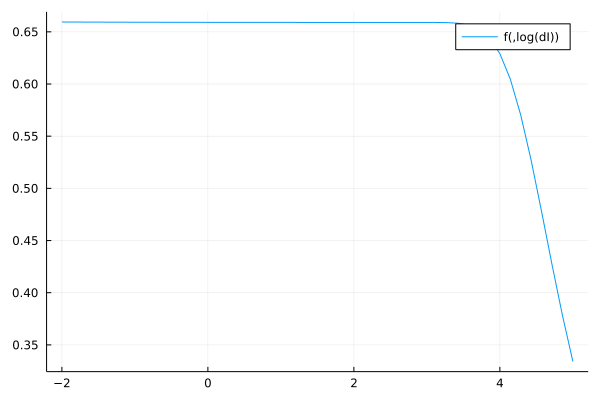

In [24]:
plot(N_range, episize_vector_I, label="f(,log(dI))")

## change $d_{S},d_{I}$

$$d_S, d_I \in [\exp(-2),\exp(5)]$$


In [ ]:
d_min = -2.0
d_max = 5.0
N_len = 20
N_range = range(d_min, d_max, length=N_len)
episize_matrix = zeros(N_len, N_len)
Threads.@threads for j in ProgressBar(1:N_len)
    for i in 1:N_len
        episize_matrix[i, j] = episize(exp(N_range[i]), exp(N_range[j]))
    end
end
episize_matrix;

$$\gamma(x) = x+1, \frac{\beta(x)}{\gamma(x)} = 3 + 0.01 * sin(2\pi  x), d_S, d_I \in [\exp(-2),\exp(5)]$$


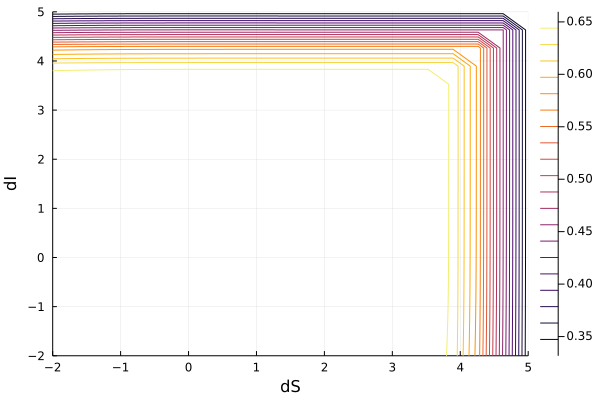

In [28]:
contour(N_range, N_range, episize_matrix, levels=20)
xlabel!("dS")
ylabel!("dI")

# Epidemic size f(dS,dI) under condition $\gamma(x) = 1, \frac{\beta(x)}{\gamma(x)} = 3 + 0.001 * sin(2\pi  x)$

$\gamma$ is constant, $\epsilon$ is small


In [ ]:
# Define functions
## recovery_rate function
function γ(x)
    y = 1.0
    return y
end
## ratio function of beta/gamma
function ratio(x, brn, ϵ)
    y = brn + ϵ * sin(2 * pi * x)
    return y
end
## initial value function
function initS(x)
    y = 0.9 + 0.1 * sin(2 * pi * x)
    return y
end
function initI(x)
    y = 0.1 + 0.1 * cos(2 * pi * x)
    return y
end


# Parameters, variables, and derivatives
@parameters t x
@parameters dS dI brn ϵ
@variables S(..) I(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2
# 1D PDE and boundary conditions
eq = [Dt(S(t, x)) ~ dS * Dxx(S(t, x)) - ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) + γ(x) * I(t, x),
    Dt(I(t, x)) ~ dI * Dxx(I(t, x)) + ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) - γ(x) * I(t, x)]
bcs = [S(0, x) ~ initS(x),
    I(0, x) ~ initI(x),
    Dx(S(t, 0)) ~ 0.0,
    Dx(S(t, 1)) ~ 0.0,
    Dx(I(t, 0)) ~ 0.0,
    Dx(I(t, 1)) ~ 0.0]
# Space and time domains
domains = [t ∈ Interval(0.0, 5.0),
    x ∈ Interval(0.0, 1.0)]
# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [S(t, x), I(t, x)], [dS => 0.5, dI => 0.1, brn => 3.0, ϵ => 1.0])
# Method of lines discretization
# Need a small dx here for accuracy
dx = 0.01
order = 2
discretization = MOLFiniteDifference([x => dx], t)

# Convert the PDE problem into an ODE problem
prob = discretize(pdesys, discretization)

# Solve ODE problem
# sol = solve(prob, Tsit5(), saveat=0.2);

# Slove SteadyState Problem
steadystateprob = SteadyStateProblem(prob)
state = solve(steadystateprob, DynamicSS(Tsit5()))
sum(state)

In [61]:
using ProgressBars
function episize(dS, dI)
    newprob = remake(prob, p=[dS, dI, 3.0, 0.001])
    steadystateprob = SteadyStateProblem(newprob)
    state = solve(steadystateprob, DynamicSS(Tsit5()))
    y = sum(state[100:end]) / 100
    return y
end

episize (generic function with 1 method)

In [ ]:
d_min = -2.0
d_max = 10.0
N_len = 50
N_range = range(d_min, d_max, length=N_len)
episize_vector_I = zeros(N_len)
Threads.@threads for j in ProgressBar(1:N_len)
        episize_vector_I[j] = episize(exp(-10.0), exp(N_range[j]))
end
episize_vector_I;

## Fix dS, Change dI

$$\gamma(x) = 1.0, \frac{\beta(x)}{\gamma(x)} = 3 + 0.001 * sin(2\pi  x),d_S=\exp(-10), d_I \in [\exp(-2),\exp(10)]$$


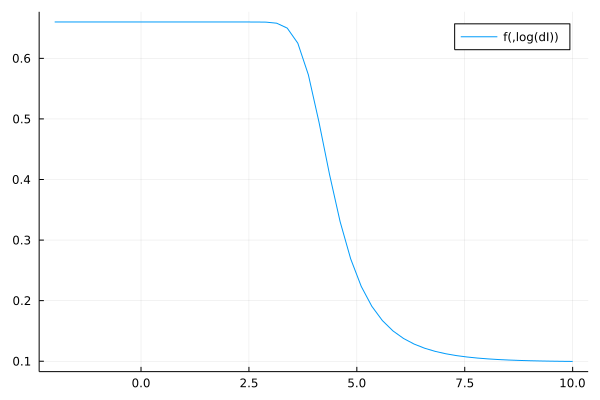

In [45]:
plot(N_range, episize_vector_I, label="f(,log(dI))")

In [62]:
d_min = 0
d_max = 10.0
N_len = 20
N_range = range(d_min, d_max, length=N_len)
episize_matrix = zeros(N_len, N_len)
Threads.@threads for j in ProgressBar(1:N_len)
    for i in 1:N_len
        episize_matrix[i, j] = episize(exp(-10.0 + N_range[i]), exp(N_range[j]))
    end
end
episize_matrix;

## Change dS, dI

$$\gamma(x) = 1.0, \frac{\beta(x)}{\gamma(x)} = 3 + 0.001 * sin(2\pi  x),d_S, d_I \in [\exp(0),\exp(10)]$$


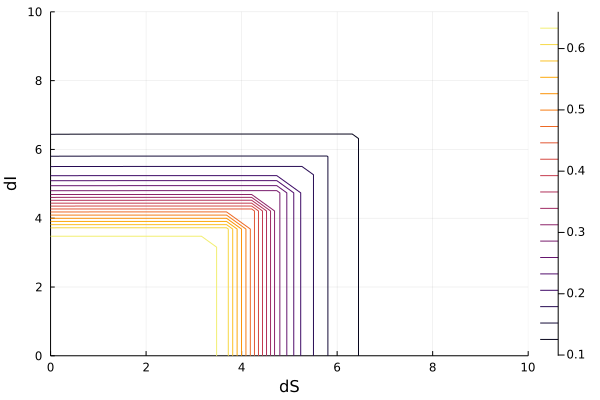

In [50]:
contour(N_range, N_range, episize_matrix, levels=20)
xlabel!("dS")
ylabel!("dI")

# Epidemic size f(dS,dI) under condition $\gamma(x) = 1, \frac{\beta(x)}{\gamma(x)} = 3 + 2 * sin(2\pi  x)$

$\gamma$ is constant, $\epsilon$ is large


In [66]:
using ProgressBars
function episize(dS, dI)
    newprob = remake(prob, p=[dS, dI, 3.0, 2.0])
    steadystateprob = SteadyStateProblem(newprob)
    state = solve(steadystateprob, DynamicSS(Tsit5()))
    y = sum(state[100:end]) / 100
    return y
end

episize (generic function with 1 method)

In [67]:
d_min = -2.0
d_max = 10.0
N_len = 50
N_range = range(d_min, d_max, length=N_len)
episize_vector_I = zeros(N_len)
Threads.@threads for j in ProgressBar(1:N_len)
        episize_vector_I[j] = episize(exp(-10.0), exp(N_range[j]))
end
episize_vector_I;

## Fix dS, Change dI

$$\gamma(x) = 1.0, \frac{\beta(x)}{\gamma(x)} = 3 + 2 * sin(2\pi  x),d_S=\exp(-10), d_I \in [\exp(-2),\exp(10)]$$


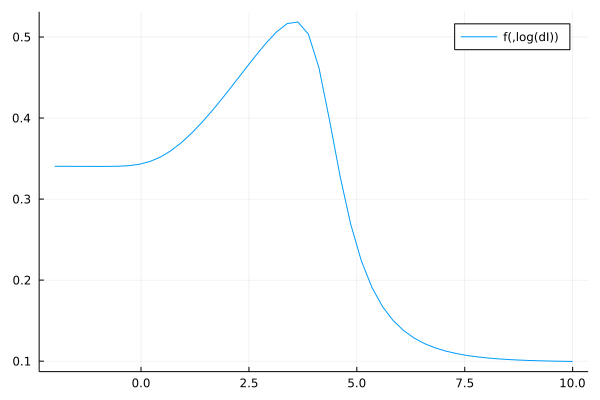

In [68]:
plot(N_range, episize_vector_I, label="f(,log(dI))")

In [ ]:
d_min = 0.0
d_max = 10.0
N_len = 20
N_range = range(d_min, d_max, length=N_len)
episize_matrix = zeros(N_len, N_len)
Threads.@threads for j in ProgressBar(1:N_len)
    for i in 1:N_len
        @inbounds episize_matrix[i, j] = episize(exp(-10 + N_range[i]), exp(N_range[j]))
    end
end
episize_matrix;

## Change dS, dI

$$\gamma(x) = 1.0, \frac{\beta(x)}{\gamma(x)} = 3 + 2 * sin(2\pi  x),d_S  \in [\exp(-10),\exp(0)], d_I \in [\exp(0),\exp(10)]$$


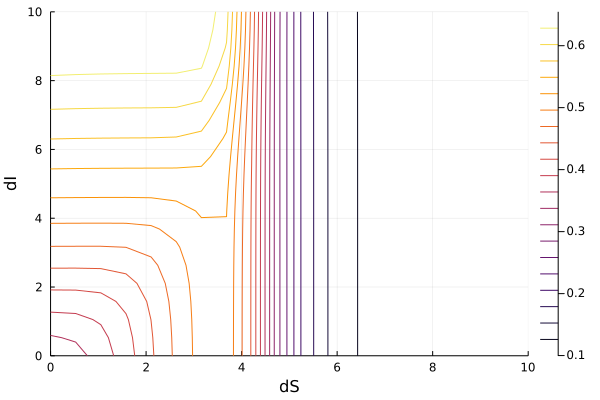

In [72]:
contour(N_range, N_range, episize_matrix, levels=20)
xlabel!("dS")
ylabel!("dI")

# Episize $\gamma(x) = 1.0, \frac{\beta(x)}{\gamma(x)} = 3 + 2 * (\exp(x) -x +1.5 - e),d_S  \in [\exp(-10),\exp(0)], d_I \in [\exp(0),\exp(10)]$


In [ ]:
# Define functions
## recovery_rate function
function γ(x)
    y = 1.0
    return y
end
## ratio function of beta/gamma
function ratio(x, brn, ϵ)
    y = brn + ϵ * (exp(x)-x+1.5-exp(1.0))
    return y
end
## initial value function
function initS(x)
    y = 0.9 + 0.1 * sin(2 * pi * x)
    return y
end
function initI(x)
    y = 0.1 + 0.1 * cos(2 * pi * x)
    return y
end

# Parameters, variables, and derivatives
@parameters t x
@parameters dS dI brn ϵ
@variables S(..) I(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2
# 1D PDE and boundary conditions
eq = [Dt(S(t, x)) ~ dS * Dxx(S(t, x)) - ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) + γ(x) * I(t, x),
    Dt(I(t, x)) ~ dI * Dxx(I(t, x)) + ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) - γ(x) * I(t, x)]
bcs = [S(0, x) ~ initS(x),
    I(0, x) ~ initI(x),
    Dx(S(t, 0)) ~ 0.0,
    Dx(S(t, 1)) ~ 0.0,
    Dx(I(t, 0)) ~ 0.0,
    Dx(I(t, 1)) ~ 0.0]
# Space and time domains
domains = [t ∈ Interval(0.0, 5.0),
    x ∈ Interval(0.0, 1.0)]
# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [S(t, x), I(t, x)], [dS => 0.5, dI => 0.1, brn => 3.0, ϵ => 1.0])
# Method of lines discretization
# Need a small dx here for accuracy
dx = 0.05
order = 2
discretization = MOLFiniteDifference([x => dx], t)

# Convert the PDE problem into an ODE problem
prob = discretize(pdesys, discretization)

# Solve ODE problem
#sol = solve(prob, Tsit5(), saveat=0.2);

# Slove SteadyState Problem
steadystateprob = SteadyStateProblem(prob)
state = solve(steadystateprob, DynamicSS(Tsit5()))
sum(state)/19



In [ ]:
function episize(dS, dI)
    newprob = remake(prob, p=[dS, dI, 3.0, 2.0])
    steadystateprob = SteadyStateProblem(newprob)
    state = solve(steadystateprob, DynamicSS(Tsit5()))
    y = sum(state[20:end]) / 19
    return y
end

d_min = -2.0
d_max = 10.0
N_len = 50
N_range = range(d_min, d_max, length=N_len)
episize_vector_I = zeros(N_len)
Threads.@threads for j in ProgressBar(1:N_len)
    episize_vector_I[j] = episize(exp(1.0), exp(N_range[j]))
end
episize_vector_I;


$$\gamma(x) = 1.0, \frac{\beta(x)}{\gamma(x)} = 3 + 2 * (\exp(x) -x +1.5 - e),d_S  \in [\exp(-10),\exp(0)], d_I \in [\exp(0),\exp(10)]$$

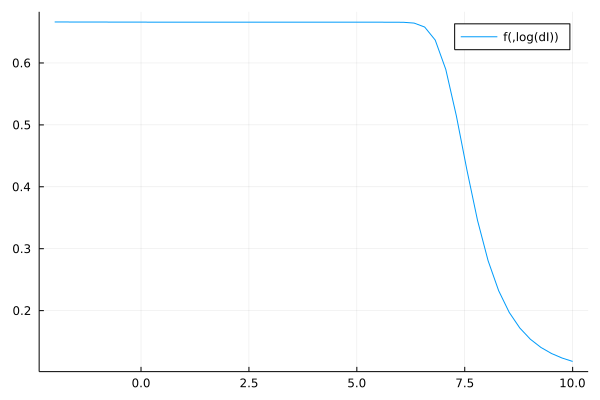

In [21]:
plot(N_range, episize_vector_I, label="f(,log(dI))")

In [ ]:
d_min = 0.0
d_max = 10.0
N_len = 20
N_range = range(d_min, d_max, length=N_len)
episize_matrix = zeros(N_len, N_len)
Threads.@threads for j in ProgressBar(1:N_len)
    for i in 1:N_len
        @inbounds episize_matrix[i, j] = episize(exp(-5 + N_range[i]), exp(N_range[j]))
    end
end
episize_matrix;

$$\gamma(x) = 1.0, \frac{\beta(x)}{\gamma(x)} = 3 + 2 * (\exp(x) -x +1.5 - e),d_S  \in [\exp(-10),\exp(0)], d_I \in [\exp(0),\exp(10)]$$

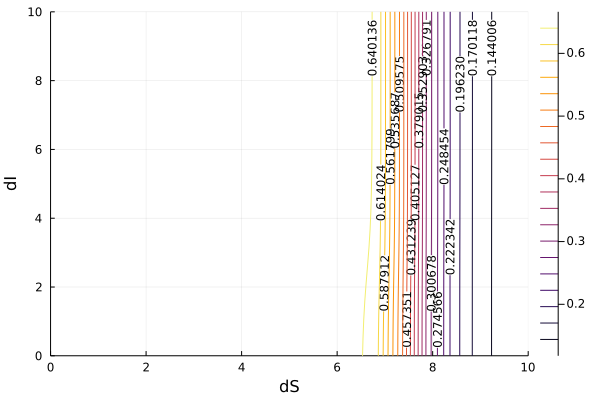

In [25]:
contour(N_range, N_range, episize_matrix, levels=20, contour_labels = true)
xlabel!("dS")
ylabel!("dI")

In [ ]:
function episize(dS, dI, ϵ)
    newprob = remake(prob, p=[dS, dI, 3.0, ϵ])
    steadystateprob = SteadyStateProblem(newprob)
    state = solve(steadystateprob, DynamicSS(Tsit5()))
    y = sum(state[20:end]) / 19
    return y
end


d_min = -5.0
d_max = 0.7
N_len = 50
N_range = range(d_min, d_max, length=N_len)
episize_vector_I = zeros(N_len)
Threads.@threads for j in ProgressBar(1:N_len)
    @inbounds episize_vector_I[j] = episize(1.0,1.0, exp(N_range[j]))
end
episize_vector_I;

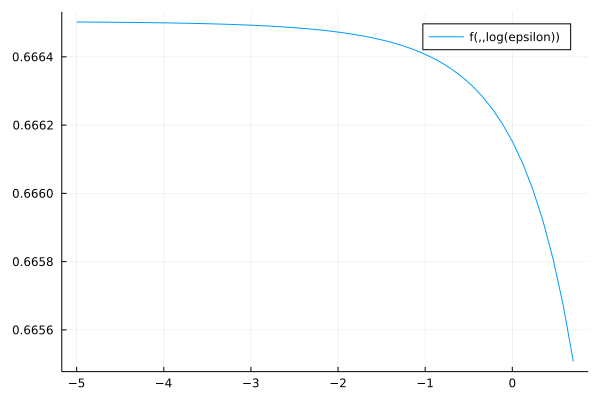

0.6655075736035115

In [27]:
display(plot(N_range, episize_vector_I, label="f(,,log(epsilon))"))
episize_vector_I[end]

# Episize $\gamma(x) = 1.0, \frac{\beta(x)}{\gamma(x)} = 3 + 2 * (\exp(x) -x +1.5 - e +\cos(2\pi x)),d_S  \in [\exp(-10),\exp(0)], d_I \in [\exp(0),\exp(10)]$


In [ ]:
# Define functions
## recovery_rate function
function γ(x)
    y = 1.0
    return y
end
## ratio function of beta/gamma
function ratio(x, brn, ϵ)
    y = brn + ϵ * (exp(x)-x+1.5-exp(1.0)+cos(2*pi*x))
    return y
end
## initial value function
function initS(x)
    y = 0.9 + 0.1 * sin(2 * pi * x)
    return y
end
function initI(x)
    y = 0.1 + 0.1 * cos(2 * pi * x)
    return y
end

# Parameters, variables, and derivatives
@parameters t x
@parameters dS dI brn ϵ
@variables S(..) I(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2
# 1D PDE and boundary conditions
eq = [Dt(S(t, x)) ~ dS * Dxx(S(t, x)) - ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) + γ(x) * I(t, x),
    Dt(I(t, x)) ~ dI * Dxx(I(t, x)) + ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) - γ(x) * I(t, x)]
bcs = [S(0, x) ~ initS(x),
    I(0, x) ~ initI(x),
    Dx(S(t, 0)) ~ 0.0,
    Dx(S(t, 1)) ~ 0.0,
    Dx(I(t, 0)) ~ 0.0,
    Dx(I(t, 1)) ~ 0.0]
# Space and time domains
domains = [t ∈ Interval(0.0, 5.0),
    x ∈ Interval(0.0, 1.0)]
# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [S(t, x), I(t, x)], [dS => 0.5, dI => 0.1, brn => 3.0, ϵ => 1.0])
# Method of lines discretization
# Need a small dx here for accuracy
dx = 0.05
order = 2
discretization = MOLFiniteDifference([x => dx], t)

# Convert the PDE problem into an ODE problem
prob = discretize(pdesys, discretization)

# Solve ODE problem
#sol = solve(prob, Tsit5(), saveat=0.2);

# Slove SteadyState Problem
steadystateprob = SteadyStateProblem(prob)
state = solve(steadystateprob, DynamicSS(Tsit5()))
sum(state)/19



In [ ]:
function episize(dS, dI)
    newprob = remake(prob, p=[dS, dI, 3.0, 2.0])
    steadystateprob = SteadyStateProblem(newprob)
    state = solve(steadystateprob, DynamicSS(Tsit5()))
    y = sum(state[20:end]) / 19
    return y
end

d_min = 0.0
d_max = 10.0
N_len = 50
N_range = range(d_min, d_max, length=N_len)
episize_vector_I = zeros(N_len)
Threads.@threads for j in ProgressBar(1:N_len)
    episize_vector_I[j] = episize(exp(-2.0),exp(N_range[j]))
end
episize_vector_I;


$$\gamma(x) = 1.0, \frac{\beta(x)}{\gamma(x)} = 3 + 2 * (\exp(x) -x +1.5 - e +\cos(2\pi x)),d_S  \in [\exp(-10),\exp(0)], d_I \in [\exp(0),\exp(10)]$$

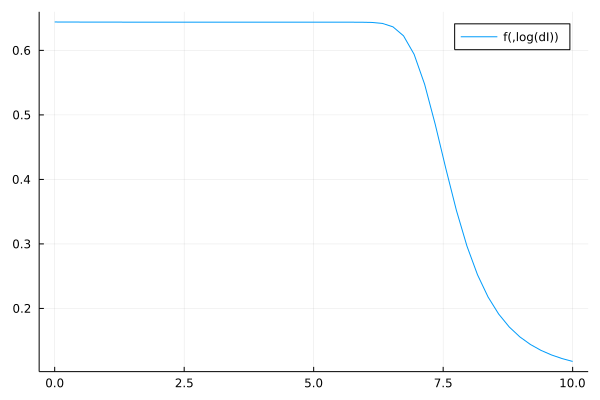

In [4]:
plot(N_range, episize_vector_I, label="f(,log(dI))")

In [40]:
d_min = 0.0
d_max = 10.0
N_len = 20
N_range = range(d_min, d_max, length=N_len)
episize_matrix = zeros(N_len, N_len)
Threads.@threads for j in ProgressBar(1:N_len)
    for i in 1:N_len
        @inbounds episize_matrix[i, j] = episize(exp(-5 + N_range[i]), exp(N_range[j]))
    end
end
episize_matrix;

$$\gamma(x) = 1.0, \frac{\beta(x)}{\gamma(x)} = 3 + 2 * (\exp(x) -x +1.5 - e +\cos(2\pi x)),d_S  \in [\exp(-10),\exp(0)], d_I \in [\exp(0),\exp(10)]$$

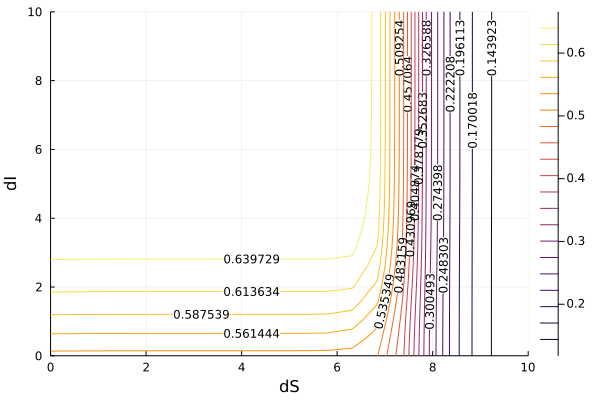

In [41]:
contour(N_range, N_range, episize_matrix, levels=20, contour_labels = true)
xlabel!("dS")
ylabel!("dI")

In [ ]:
function episize(dS, dI, ϵ)
    newprob = remake(prob, p=[dS, dI, 3.0, ϵ])
    steadystateprob = SteadyStateProblem(newprob)
    state = solve(steadystateprob, DynamicSS(Tsit5()))
    y = sum(state[20:end]) / 19
    return y
end


d_min = -5.0
d_max = 0.8
N_len = 50
N_range = range(d_min, d_max, length=N_len)
episize_vector_I = zeros(N_len)
Threads.@threads for j in 1:N_len
    @inbounds episize_vector_I[j] = episize(1.0,1.0, -2.0 + 2.0*exp(N_range[j]))
end
episize_vector_I;

$$\gamma(x) = 1.0, \frac{\beta(x)}{\gamma(x)} = 3 + 2 * (\exp(x) -x +1.5 - e +\cos(2\pi x)),d_S  \in [\exp(-10),\exp(0)], d_I \in [\exp(0),\exp(10)]$$

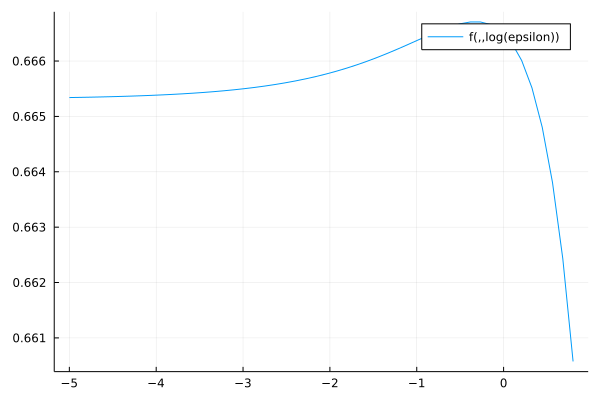

0.6605748769366037

In [8]:
display(plot(N_range, episize_vector_I, label="f(,,log(epsilon))"))
episize_vector_I[end]

In [ ]:
using Integrals
f(x, p) = ratio(x, 3.0, exp(0.9))
integralprob = IntegralProblem(f,0.0,1.0)
solve(integralprob, QuadGKJL())